In [1]:
import baltic as bt
from matplotlib import pyplot as plt
from collections import defaultdict
from matplotlib import cm
from numpy import linspace
%matplotlib inline
import json
import matplotlib.gridspec as gridspec
import math
from itertools import combinations
import pandas as pd

import numpy as np
import seaborn as sns
from pprint import pprint
import math
import sequtils as sue
from scipy.stats import linregress
from copy import deepcopy

sns.set(style='whitegrid', font_scale = 1.2)

## First, assign genotypes and serotypes  

In [7]:
out_path = '../data/'
tree_path = '../titer_model/shared_output/dengue_all_tree.json'
freqs_path = '../titer_model/shared_output/dengue_all_frequencies.json'
reference_path = '../data/reference/genotype_refs_pyke2016.csv'

In [8]:
def assign_genotype_attr(tree, mrcas, trait='genotype'):
    ''' Takes the most basal node with each genotype annotation, 
    propagates the genotype assignment to its monophyletic descendents'''
    
    for k in tree.Objects: # remove old annotations
        k.traits = { key:value for key,value in k.traits.items()
                    if key not in (trait, '%s_mrca'%trait)}
        
    def annotate(genotype, node):
        node.traits['%s_mrca'%trait] = True
        node.traits[trait] = genotype
        for child in tree.traverse_tree(node, include_all=True):
            if trait in child.traits:
                if genotype != child.traits[trait]:
                    print 'ERROR: Overlapping %s trait %s and %s at index %s'%(trait, child.traits[trait], trait, child.index)
            child.traits[trait] = genotype
        
    for genotype, mrca in mrcas.items():
        if isinstance(mrca, list):
            for node in mrca:
                annotate(genotype, node)
        else:
            annotate(genotype, mrca)

    return tree

def load_tree_find_mrcas(path = tree_path):    
    '''Initially, genotype mrcas are as designated by augur.'''
    json_translation = {
        'name': 'strain',
        'height': 'xvalue',
    }
    tree = bt.loadJSON(path, json_translation) ## baltic Tree object
    mrcas = { node.traits['clade_name']: node 
             for node in tree.Objects if 'clade_name' in node.traits}
    tree = assign_genotype_attr(tree, mrcas)
    return {'tree': tree, 'mrcas': mrcas, 'genotypes': list(set(mrcas.keys()))}

def annotate_references(tree, path=reference_path):
    refs = pd.read_csv(path, names=['serotype', 'genotype', 'year', 'accession', 'country', 'location'])
    refs['sero_geno'] = refs['serotype']+'_'+refs['genotype']
    ref_map = {acc:geno.upper() for (acc, geno) in zip(refs['accession'], refs['sero_geno'])}
    for k in tree.Objects:
        if k.branchType=='leaf' and k.traits['accession'] in ref_map:
            k.traits['reference_genotype'] = ref_map[k.traits['accession']]
    return tree

def init_genotypes_from_references(tree):
    genotype_refs = defaultdict(list)
    for k in tree.Objects:
        if 'reference_genotype' in k.traits:
            genotype_refs[k.traits['reference_genotype']].append(k)
    genotype_mrcas = {}
    for gt, tips in genotype_refs.items():
        genotype_mrcas[gt] = tree.commonAncestor(tips, numName=True)
    return genotype_mrcas

def assign_genotype_colors(genotypes):
    ''' {'denv2/asianI': viridis[0], ...}'''
    cmaps = [cm.Blues, cm.Greens, cm.Purples, cm.Reds]
    
    if genotypes[0].startswith('DENV'):
        color_dict = {}
        for i, sero in enumerate(['DENV1', 'DENV2', 'DENV3', 'DENV4']):
            cmap = cmaps[i]
            color_dict[sero] = cmap(.5)
            geno = sorted([ g for g in genotypes if g.startswith(sero)])
            cm_subsection = linspace(0.25, 0.75,len(geno))
            colors = [ cmap(g) for g in cm_subsection]
            color_dict.update({g:color for (g,color) in zip(geno, colors)})

    else:
        cmap = cmaps[1]
        genotypes.sort()
        cm_subsection = linspace(0.25, 0.75,len(genotypes))
        colors = [ cmap(g) for g in cm_subsection]
        color_dict = {g:color for (g,color) in zip(genotypes, colors)}

    return color_dict

In [9]:
#### Parse the tree & assign genotypes
default_annotations = load_tree_find_mrcas()

# bt.tree with k.traits['genotype'] initially assigned by augur-inferred clade_name trait
tree = annotate_references(default_annotations['tree'])

# {'DENV2_AMERICAN': <baltic node>}
mrcas = default_annotations['mrcas']
if mrcas == {}:
    mrcas = init_genotypes_from_references(tree)

# ['denv2_american', 'denv1_I', ...]
genotypes = mrcas.keys()

# {'denv2_american': color}
colors = assign_genotype_colors(genotypes)


Tree height: 0.459920
Tree length: 9.892780
annotations present

Numbers of objects in tree: 4700 (2140 nodes and 2560 leaves)



In [11]:
for k in tree.Objects:
    k.traits['clade'] = str(k.traits['clade'])

tree_string = tree.toString(traits=['clade', 'reference_genotype', 'genotype'], numName=True, nexus=True)
open(out_path + '/trees/tmp_genotype_annotation.nexus', 'w').write(tree_string)

for k in tree.Objects:
    k.traits['clade'] = int(k.traits['clade'])
################################
'''
Now open tmp_genotype_annotation.nexus in figtree, select:
appearance > colorby > reference_genotype
tip labels > reference_genotype
branch labels > clade

fill in the clade # for each genotype MRCA below, 
then run the cell to update the attributes in the tree and pull the correct frequency vectors
'''
#################################
pass

In [12]:
serotype_mrcas = {
            'DENV1': 2914,
            'DENV2': 610, 
            'DENV3': 2122,
            'DENV4':1}

mrcas['DENV1_I'] = 4054
mrcas['DENV1_II'] = 3611
mrcas['DENV1_IV'] = 3619
mrcas['DENV1_V'] = 2942
# mrcas['DENV1_III'] = 
# mrcas['DENV1_SYLVATIC'] = 2971

mrcas['DENV3_I'] = 2125
mrcas['DENV3_II'] = 2305
mrcas['DENV3_III'] = 2453
mrcas['DENV3_V'] = 2293

mrcas['DENV4_SYLVATIC'] = 2 
mrcas['DENV4_I'] = 10
mrcas['DENV4_II'] = 162
mrcas['DENV4_III'] = 6

mrcas['DENV2_AMERICAN'] = 624
mrcas['DENV2_ASIANII'] = 1355
mrcas['DENV2_COSMOPOLITAN'] = 732
mrcas['DENV2_ASIANI'] = 1410
mrcas['DENV2_SYLVATIC'] = 611
mrcas['DENV2_ASIANAMERICAN'] = 1619

def lookup_node(clade, tree):
    try:
        return [k for k in tree.nodes if k.traits['clade'] == clade][0]
    except:
        return None

def update_annotations(mrcas=mrcas, tree=tree, attr='genotype'):
    for genotype, mrca in mrcas.items():
        if not isinstance(mrca, list):
            node = lookup_node(mrca, tree)
            if node is None:
                print '%s mrca not found'%(genotype)
            if node:
                mrcas[genotype] = node
            else:
                del mrcas[genotype]
                
        elif isinstance(mrca, list):
            nodes = [lookup_node(genotype, node, tree) for node in mrca]
            nodes = [n for n in nodes if n != None]
            if nodes != []:
                mrcas[genotype] = nodes
            else:
                print 'No MRCAs found for genotype %s'%genotype
                del mrcas[genotype]
    assign_genotype_attr(tree, mrcas, attr)

update_annotations(mrcas, tree, 'genotype')
update_annotations(serotype_mrcas, tree, 'serotype')

genotypes = mrcas.keys()
colors = assign_genotype_colors(genotypes)

DENV1_III mrca not found
DENV1_SYLVATIC mrca not found


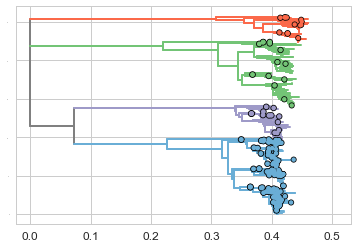

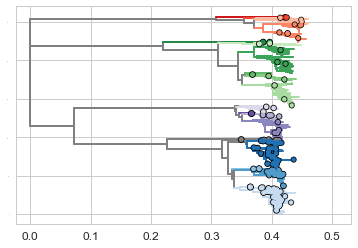

In [13]:
def plot_tree(tree, labels=False, colorby='genotype'):
    branchWidth=2 ## default branch width
    ll = tree
    max_x = max([k.x for k in tree.Objects])
    plt.yticks(size=0)
    
    for k in ll.Objects: ## iterate over objects in tree
        x=k.x ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
        c = colors[k.traits[colorby]] if k.traits.has_key(colorby) else 'gray'
            
        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            s=50 ## tip size can be fixed
            s=50-30*k.height/ll.treeHeight
            
            if 'reference_genotype' in k.traits:
                plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
                plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
                        
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            plt.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
            
            if labels and 'reference_genotype' in k.traits:
                ax.text(max_x, y, k.traits['reference_genotype'])
            
        plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    x0,x1 = plt.xlim()
    plt.xlim((x0, x1*1.1))
    
def plot_subtrees(tree, mrcas = serotype_mrcas, labels = False):
    sns.set(style='whitegrid', font_scale=1.3)
    figure = plt.figure(figsize=(10,50))
    serotypes = ['DENV1', 'DENV2', 'DENV3', 'DENV4']
    serotype_tips = { sero: [k for k in tree.Objects if k.branchType=='leaf' and k.numName.startswith(sero)] for sero in serotypes}
    
    for i, serotype in enumerate(serotypes, start=1):
        mrca = mrcas[serotype]
        plt.subplot(4, 1,i)
        subtree = tree.subtree(mrca,absoluteTime=False)
        plot_tree(subtree, labels=labels, colorby='genotype')
    plt.tight_layout()
    plt.show()

plot_tree(tree, colorby='serotype')
plt.show()
plt.clf()

plot_tree(tree, colorby='genotype')

In [7]:
tree_string = tree.toString(traits=['clade', 'reference_genotype', 'genotype', 'serotype', 'dTiter', 'cTiter'], 
                            numName=True, nexus=True)
open(out_path+'trees/genotype_tree.nexus', 'w').write(tree_string)

## Next, parse frequencies of each named clade (serotypes + genotypes)

In [18]:
def normalize_frequencies_by_timepoint(frequencies):
    ''' Normalize each row so that the sum of all frequencies at a single timepoint = 1'''
    def normalize(row):
        total = row.sum()
        if np.isnan(total) or total == 0:
            return row
        else:
            return row.map( lambda x: x / total)

    if isinstance(frequencies, dict):
        frequencies = pd.DataFrame(frequencies)
        normalized_frequencies = frequencies.apply(normalize, axis=1)
        return normalized_frequencies.to_dict()

    else:
        normalized_frequencies = frequencies.apply(normalize, axis=1)
        return normalized_frequencies

def load_frequencies(mrcas, path, region='southeast_asia'):
    '''
    {'south_america': 
            {0: [ 0.1, 0.4, 0.23, ....]},
        }, 
    'pivots': [1900, 1901, ...]
    'genotypes': set('DENV2_AMERICAN', ...)}
    '''        
    all_frequencies = json.load(open(path, 'r')) ## {'southeast_asia_clade:179':[0.1, 0.23, ...]}
    pivots = all_frequencies.pop('pivots') # [1917., 1918., ...]
    
    region_frequencies = {}    
    for label, freqs in all_frequencies.items():
        if region not in label:
            continue
        elif 'clade' in label:
            label = int(label.split(':')[1])
            region_frequencies[label] = freqs
        else:    
            print 'IDK what to do with this label%s'%label
    
    named_frequencies = {}
    for name, node in mrcas.items():
        named_frequencies[name] = region_frequencies[node.traits['clade']]
        
    return {'pivots': pivots, 'frequencies': named_frequencies}


def make_dataframe(frequencies, pivots, mindate=1970., name='frequencies', save=True):
    ''' dataframe with genotypes as columns, pivots as index, region-specific frequencies as values'''
    non_sylvatic = { k:v for k,v in frequencies.items() if 'SYLVATIC' not in k.upper() }
    df = pd.DataFrame(non_sylvatic, index=pivots)
    df = df.loc[df.index[df.index >= mindate]]
    df = normalize_frequencies_by_timepoint(df)
    
    if save:
        df.to_csv(out_path+name+'.csv')
    return df

In [19]:
genotype_frequencies = load_frequencies(mrcas, freqs_path)
genotype_frequencies = make_dataframe(genotype_frequencies['frequencies'], genotype_frequencies['pivots'], name='genotype_frequencies')

serotype_frequencies = load_frequencies(serotype_mrcas, freqs_path)
serotype_frequencies = make_dataframe(serotype_frequencies['frequencies'], serotype_frequencies['pivots'], name='serotype_frequencies')
pivots = serotype_frequencies.index.values

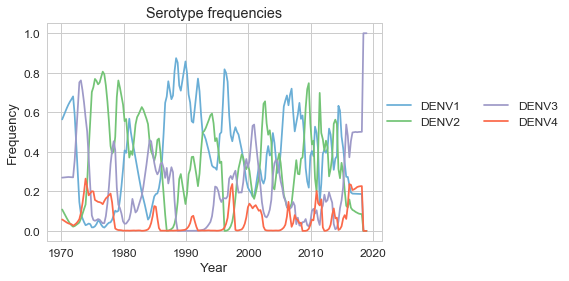

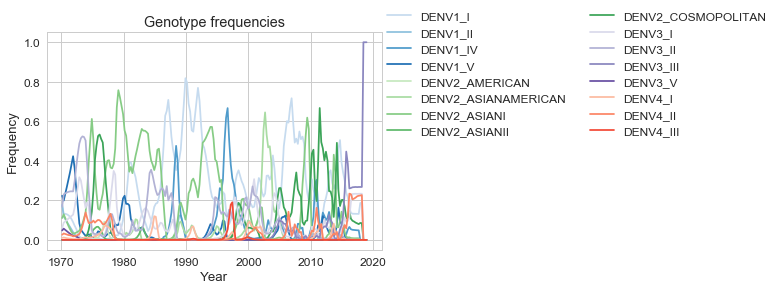

In [21]:
def plot_region_frequencies(freqs, title, date_range = None, pivots=pivots):
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Frequency')

    if date_range:
        pivots = [i for i in pivots if i > date_range[0] and i < date_range[1]]
        freqs = freqs.ix[pivots]
    
    for clade, freqs in freqs.iteritems():
        plt.plot(pivots, freqs, color=colors[clade], label=clade)   
    plt.legend(loc=(1,.5), ncol=2)
    plt.show()

plot_region_frequencies(serotype_frequencies, 'Serotype frequencies')
plot_region_frequencies(genotype_frequencies, 'Genotype frequencies')

In [22]:
genotype_frequencies.to_csv(out_path+'frequencies/genotype_frequencies.csv')
serotype_frequencies.to_csv(out_path+'frequencies/serotype_frequencies.csv')

## Finally, parse titers. Output pairwise distances and label the tree.

In [24]:
full_tree_titer_values = json.load(open('../titer_model/full_tree_model_output/dengue_all_tree_model.json', 'r'))
interserotype_titer_values = json.load(open('../titer_model/interserotype_model_output/dengue_all_tree_model.json', 'r'))

def assign_tree_titer_values(titers, tree):
    for clade, dTiter in titers['dTiter'].items():
        node = lookup_node(int(clade), tree)
        node.traits['dTiter'] = dTiter
        
    for clade in tree.traverse_tree(include_all=True):
        if 'dTiter' not in clade.traits:
            clade.traits['dTiter'] = 0.
        
        if clade.parent is not None and clade.index != 'Root':
            clade.traits['cTiter'] = clade.parent.traits['cTiter'] + clade.traits['dTiter']
        else:
            clade.traits['cTiter']=0.

full_tree = deepcopy(tree)
assign_tree_titer_values(full_tree_titer_values, full_tree)
interserotype_tree = deepcopy(tree)
assign_tree_titer_values(interserotype_titer_values, interserotype_tree)

In [25]:
full_tree_string = full_tree.toString(traits=['clade', 'genotype', 'serotype', 'dTiter', 'cTiter'], numName=True, nexus=True)
open(out_path+'trees/full_titer_tree.nexus', 'w').write(full_tree_string)

interserotype_tree_string = interserotype_tree.toString(traits=['clade', 'genotype', 'serotype', 'dTiter', 'cTiter'], numName=True, nexus=True)
open(out_path+'trees/interserotype_titer_tree.nexus', 'w').write(interserotype_tree_string)

In [29]:
def get_path_total(k1, k2, tree, trait='dTiter'):

    if k1 not in tree.Objects or k2 not in tree.Objects:
        if type(k1) == list:
            k1 = min(k1)
        if type(k2) == list:
            k2 = min(k2)
        k1 = [k for k in tree.Objects if k.traits['clade']==k1.traits['clade']][0]
        k2 = [k for k in tree.Objects if k.traits['clade']==k2.traits['clade']][0]
    k1_trace = []
    k2_trace = []
    k = k1 ## Trace from the node 1 to the root (in order)
    while k.index != 'Root':
        k1_trace.append(k)
        k = k.parent
    k = k2 ## Start tracing from node2 to the root; break when we find the first node that's shared along node1's path
    while k not in k1_trace:
        k2_trace.append(k)
        k = k.parent
    else: # first shared node is the Most Recent Common Ancestor (MRCA)
        mrca = k
    shared_k1_trace = k1_trace[:k1_trace.index(mrca)]
    k2_trace.reverse() # walk back down from the mrca, so the path is unidirectional (doesn't matter, but makes my type-A brain happy)
    total_trace = [] # verbose for clarity
    total_trace += shared_k1_trace
    total_trace += k2_trace

    try:
        trait_sum = sum([k.traits[trait] for k in total_trace]) # sum up dTiter values along the path between clade1 and clade2    
    except KeyError:
        trait_sum = sum([getattr(k, trait) for k in total_trace]) # sum up dTiter values along the path between clade1 and clade2    
    return trait_sum

In [30]:
full_tree_Dij = { tuple(sorted([i,j])) : get_path_total(mrcas[i], mrcas[j], full_tree) 
                  for (i,j) in combinations(mrcas.keys(), 2)}

full_tree_Dij.update({ tuple(sorted([i,j])) : get_path_total(serotype_mrcas[i], serotype_mrcas[j], full_tree) 
                  for (i,j) in combinations(serotype_mrcas.keys(), 2)})

interserotype_Dij = { tuple(sorted([i,j])) : get_path_total(mrcas[i], mrcas[j], interserotype_tree) 
                  for (i,j) in combinations(mrcas.keys(), 2)}

interserotype_Dij.update({ tuple(sorted([i,j])) : get_path_total(serotype_mrcas[i], serotype_mrcas[j], interserotype_tree) 
                  for (i,j) in combinations(serotype_mrcas.keys(), 2)})

In [31]:
pd.Series(full_tree_Dij).reset_index().to_csv(out_path+'frequencies/full_tree_Dij.csv', header=False, index=False)
pd.Series(interserotype_Dij).reset_index().to_csv(out_path+'frequencies/interserotype_Dij.csv', header=False, index=False)

## While we're at it, pull the patristic distances for each pair of titered strains

In [40]:
titers = pd.read_csv('../data/titers_katzelnick2015/dengue_titers.tsv', sep='\t')
titered_strains = set(titers['virus_strain'].values).union(set(titers['serum_strain'].values))
titered_tips = [k for k in tree.Objects if k.traits['strain'] in titered_strains]

In [23]:
titered_tip_distances = { tuple(sorted([i.traits['strain'],j.traits['strain']])) : get_path_total(i, j, tree, trait='length') 
                  for (i,j) in combinations(titered_tips, 2)}

In [24]:
titered_tip_distances = pd.Series(titered_tip_distances).reset_index()
titered_tip_distances.to_csv(out_path+'trees/tip_distances.csv', header=False, index=False)